In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
f0 = 5e6 # start frequency [Hz]
B = 10e6 # bandwidth [Hz]
def generate_chirp(P, tau, t, f0=5e6, B=10e6):
    # Generate unit-amplitude complex chirp
    chirp = scipy.signal.chirp(t,  f0=f0, t1=tau, f1=f0 + B, method='linear',
        phi=-90,
        complex=True
    )
    # Normalize to unit average power
    chirp /= np.sqrt(np.mean(np.abs(chirp)**2))
    # Scale to desired power
    chirp *= np.sqrt(P)
    return chirp

# -----------------------------
# Radar / chirp parameters
# -----------------------------
P_chirp = 1 # chirp power [W]
T_p = 1e-3 # pulse repetition interval [s] = 1000 us
fs = 100e6 # sampling rate [Hz] (100 MHz)
tau = 128 / fs

# -----------------------------
# Time axes
# -----------------------------
N_total = int(T_p * fs)
N_chirp = int(tau * fs)
t = np.arange(N_total) / fs
t_chirp = np.arange(N_chirp) / fs


SNR_dB = 20
chirp = generate_chirp(P_chirp, tau, t_chirp)

noise_power = P_chirp / (10**(SNR_dB / 10))
noise_std = np.sqrt(noise_power / 2)
noise = noise_std * (np.random.randn(N_total) + 1j * np.random.randn(N_total))
signal = np.zeros(N_total, dtype=np.complex64)
signal[:N_chirp] = chirp

rx = signal + noise

chirp_avg_power = np.mean(np.abs(chirp)**2)
noise_avg_power = np.mean(np.abs(noise)**2)

chirp_avg_power, noise_avg_power

(np.float64(1.0), np.float64(0.009994538557321055))

In [3]:
chirp_fft = np.fft.fft(chirp)
rx_fft = np.fft.fft(rx)

/u/11/suominm16/unix/anaconda3/envs/aalto/lib/python3.14/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/u/11/suominm16/unix/anaconda3/envs/aalto/lib/python3.14/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


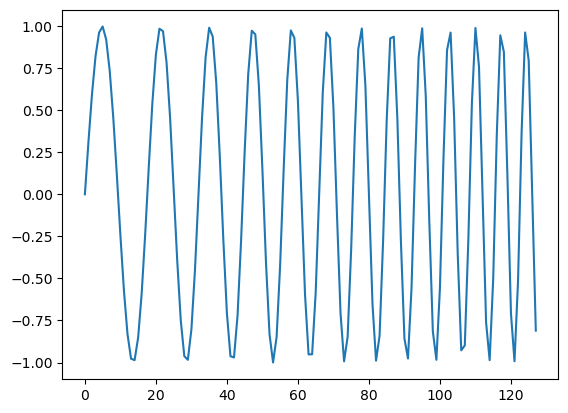

In [4]:
plt.plot(chirp)

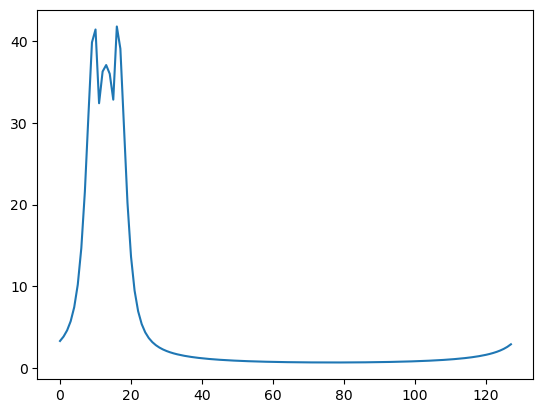

In [5]:
plt.plot(np.abs(chirp_fft))

In [6]:
# These are working now
def dft_naive(x):
    n = len(x)
    X = np.zeros(n,dtype=np.complex64)
    for k in range(n):
        for m in range(n):
            X[k] += x[m]*np.exp(-1j*2*np.pi*k*m/n)
    return X

def idft_naive(X):
    N = len(X)
    x = np.zeros(N,dtype=np.complex64)
    for n in range(N):
        for k in range(N):
            x[n] += 1/N*X[k]*np.exp(1j*2*np.pi*k/N*n) 
    return x

In [7]:
chirp_dft_own = dft_naive(chirp)

In [8]:
chirp_back = idft_naive(chirp_dft_own)

In [9]:
np.allclose(chirp, chirp_back, 0.0001)

True

In [10]:
np.allclose(chirp_dft_own,chirp_fft,0.00001)

True

In [11]:
def fft_recursion(input):
    N = len(input)
    if(N == 1):
        return input

    # Split the input to evens and oods
    evens = []
    odds = []
    for k in range(0,N,2):
        evens.append(input[k])
        odds.append(input[k+1])
    
    # Compute the FFT results for the evens and odds
    evenResults = fft_recursion(evens)
    oddResults = fft_recursion(odds)
    
    w_N = np.exp(2*np.pi*1j/N)
    finalResult = [0 for _ in range(N)]
    for k in range(N):
        finalResult[k] = evenResults[k % int(N/2)] + w_N**(-k) * oddResults[k % int(N/2)]
    
    return finalResult

def ifft_recursion(input):
    N = len(input)
    if (N == 1):
        return input

    # Split the input to evens and odds
    evens = []
    odds = []
    for k in range(0, N, 2):
        evens.append(input[k])
        odds.append(input[k+1])

    # Recursive calls
    evenResults = ifft_recursion(evens)
    oddResults = ifft_recursion(odds)

    # NOTE: sign flipped here
    w_N = np.exp(-2*np.pi*1j / N)

    finalResult = [0 for _ in range(N)]
    for k in range(N):
        finalResult[k] = (
            evenResults[k % int(N/2)]
            + w_N**(-k) * oddResults[k % int(N/2)]
        )

    return finalResult


In [12]:
print(chirp.size)

128


In [13]:
def fft_own(x):
    X = fft_recursion(x.tolist())
    return X

def ifft_own(X):
    N = len(X)
    x = ifft_recursion(X)
    return [v / N for v in x]

In [14]:
chirp_fft_own = fft_own(chirp)

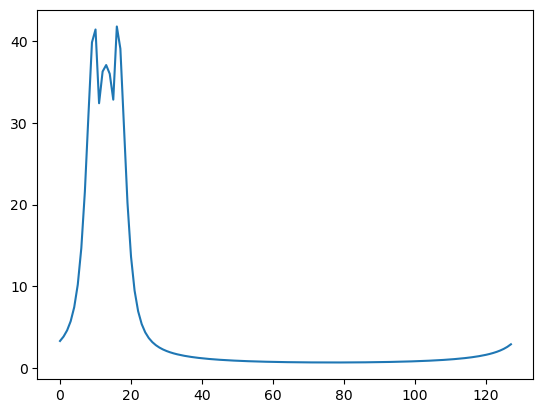

In [15]:
plt.plot(np.abs(chirp_fft_own))

In [16]:
np.allclose(chirp_dft_own, chirp_fft_own)

True

In [17]:
chirp_back_fft_own = ifft_own(chirp_fft_own)

In [18]:
np.allclose(chirp_back_fft_own, chirp,0.00001)

True

In [28]:
print(chirp)

[ 6.12323400e-17-1.j          3.11350305e-01-0.95029521j
  5.95699304e-01-0.80320753j  8.21802350e-01-0.56977267j
  9.62455236e-01-0.27144045j  9.98118113e-01+0.06132074j
  9.20078084e-01+0.39173501j  7.32654272e-01+0.680601j
  4.53990500e-01+0.89100652j  1.15099689e-01+0.99335395j
 -2.42980180e-01+0.97003125j -5.73799804e-01+0.8189956j
 -8.31469612e-01+0.55557023j -9.77288933e-01+0.21191117j
 -9.86104976e-01-0.16612338j -8.51355193e-01-0.52458968j
 -5.87785252e-01-0.80901699j -2.31058108e-01-0.97293995j
  1.66123378e-01-0.98610498j  5.41203809e-01-0.84089145j
  8.31469612e-01-0.55557023j  9.84855072e-01-0.17337961j
  9.70031253e-01+0.24298018j  7.83795082e-01+0.62101954j
  4.53990500e-01+0.89100652j  3.68072229e-02+0.99932238j
 -3.91735011e-01+0.92007808j -7.49136395e-01+0.66241578j
 -9.62455236e-01+0.27144045j -9.83992134e-01-0.17821189j
 -8.03207531e-01-0.5956993j  -4.51802276e-01-0.8921181j
 -4.28626380e-16-1.j          4.56175989e-01-0.88988958j
  8.14748483e-01-0.57981455j  9.909

In [27]:
print(chirp_back_fft_own)

[np.complex128(-1.3322676295501878e-15-1.0000000000000004j), np.complex128(0.31135030516243095-0.9502952106978434j), np.complex128(0.5956993044924327-0.8032075314806439j), np.complex128(0.8218023498911449-0.5697726719608323j), np.complex128(0.9624552364536485-0.2714404498650753j), np.complex128(0.9981181129001492+0.06132073630220819j), np.complex128(0.9200780843345951+0.39173501085195583j), np.complex128(0.7326542716724109+0.6806009977954527j), np.complex128(0.4539904997395472+0.8910065241883695j), np.complex128(0.11509968919221514+0.9933539457554166j), np.complex128(-0.24298017990326426+0.9700312531945431j), np.complex128(-0.5737998040863479+0.8189955951227472j), np.complex128(-0.831469612302547+0.5555702330196028j), np.complex128(-0.9772889326079102+0.2119111658268404j), np.complex128(-0.9861049757675077-0.16612337814576614j), np.complex128(-0.8513551931052621-0.5245896826784682j), np.complex128(-0.5877852522924742-0.8090169943749478j), np.complex128(-0.23105810828067103-0.9729399522

Let's try the convolution with the fourier

In [19]:
N = 1024
M = 128
x = np.random.randint(-50, 50, N) + 1j * np.random.randint(-50, 50, N)
kernel = np.random.randint(-50, 50, M) + 1j * np.random.randint(-50, 50, M)

In [20]:
L = 1 << int(np.ceil(np.log2(N + M - 1)))  # next power of 2

x_pad = np.pad(x, (0, L - N))
kernel_pad = np.pad(kernel, (0, L - M))

In [21]:
x_pad.shape

(2048,)

In [22]:
convolved = np.convolve(x, kernel)
convolved_with_fft = ifft_own( np.array(fft_own(x_pad)) * np.array(fft_own(kernel_pad)) )[:N + M - 1]

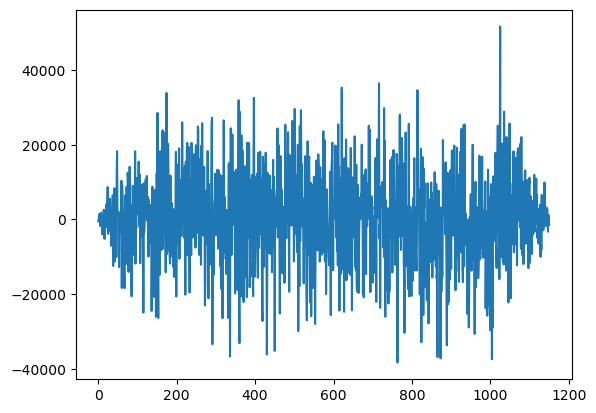

In [23]:
plt.plot(convolved_with_fft)

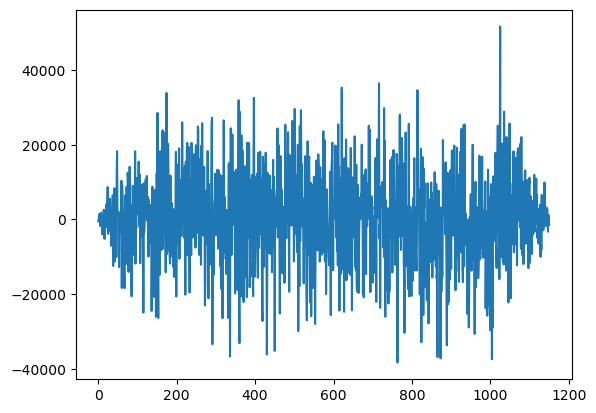

In [24]:
plt.plot(convolved)

In [25]:
np.allclose(convolved, convolved_with_fft)

True

In [26]:
print(chirp_dft_own)

[  3.3128161 +4.36360031e-01j   3.8615463 +4.01199192e-01j
   4.6311665 +2.82552302e-01j   5.752501  -3.57420184e-02j
   7.42108   -8.55158031e-01j   9.791249  -2.95052004e+00j
  12.278557  -8.06206799e+00j  11.129911  -1.85024662e+01j
  -3.64344   -3.06773129e+01j -34.458782  -1.99633446e+01j
 -29.801054  +2.87292099e+01j  29.613123  +1.31078959e+01j
 -24.88551   -2.63811073e+01j  13.149422  +3.46396599e+01j
 -29.360348  -2.08019791e+01j  32.80153   +1.17060411e+00j
  -8.127995  +4.09643707e+01j -37.508568  +1.08444099e+01j
 -26.26304   -1.34012384e+01j -11.271788  -1.67894688e+01j
  -3.6648192 -1.31366739e+01j  -0.8407486 -9.46062183e+00j
   0.05558082-6.97743034e+00j   0.30103177-5.40485191e+00j
   0.34477687-4.38344812e+00j   0.33186764-3.68652439e+00j
   0.3075334 -3.18681550e+00j   0.28513858-2.81283092e+00j
   0.2679258 -2.52289510e+00j   0.25599468-2.29156971e+00j
   0.24858639-2.10261226e+00j   0.24481627-1.94522595e+00j
   0.24389659-1.81197166e+00j   0.24518508-1.69757009e+0